# Model building

## Define Data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [34]:
#load the training data
df = pd.read_csv("data_train.csv", index_col=0)

In [35]:
#encode categorical variables
df['explicit'] = df['explicit'].astype(int)
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
84744,28,293960,0,0.640,0.593,9,-10.663,0,0.0396,0.3960,0.024700,0.0599,0.528,97.404,4,psych-rock,1
89295,1,147133,1,0.835,0.718,7,-5.620,0,0.0694,0.2260,0.000002,0.1080,0.427,92.028,4,reggaeton,2
66688,11,98386,0,0.786,0.225,9,-16.516,1,0.5730,0.6790,0.000000,0.2010,0.658,110.066,4,kids,4
51391,61,232173,0,0.709,0.829,0,-5.817,1,0.2450,0.0698,0.000000,0.5610,0.654,137.954,4,hip-hop,0
95123,37,360320,0,0.786,0.702,0,-6.742,1,0.0456,0.5110,0.000000,0.1200,0.696,104.030,4,salsa,7


In [36]:
#Overview of the top 'n' genres and the proportion of songs within each cluster of the training df
n = 5

song_count = len(df)
genre_dict = {cluster: list(df['track_genre'][df['cluster'] == cluster].value_counts().index[:n]) for cluster in df['cluster'].unique()}
cluster_df = pd.DataFrame({"cluster":df['cluster'], "genre": df['track_genre']})
count_dict_unformatted = cluster_df['cluster'].value_counts().to_dict()
count_dict = pd.DataFrame({k: [f"{v/song_count*100:.0f}%"] for k,v in count_dict_unformatted.items()})

summary_df = pd.concat([pd.DataFrame(genre_dict), pd.DataFrame(count_dict)], ignore_index = True)
summary_df.rename({i: i+1 for i in range(len(summary_df))}).rename({len(summary_df): "Percent of Data"})

,1,2,4,0,7,3,5,6
1,tango,kids,comedy,pagode,k-pop,metalcore,new-age,minimal-techno
2,romance,latin,show-tunes,samba,pop-film,heavy-metal,classical,detroit-techno
3,honky-tonk,party,funk,sertanejo,forro,death-metal,sleep,techno
4,cantopop,salsa,kids,mpb,deep-house,hardstyle,ambient,chicago-house
5,jazz,reggae,children,gospel,turkish,grunge,piano,trance
Percent of Data,18%,19%,1%,6%,21%,18%,6%,10%


In [37]:
#Example for binary cluster classification
selected_cluster = 3

#Coerce boolean to binary
df[f'cluster{selected_cluster}_binary'] = (df['cluster'] == selected_cluster) *1

#Drop columns (should we drop track_genre??) and create training/testing 
#NOTE a testing csv has already been witheld
X = df.drop(labels = ['track_genre', 'cluster'], axis=1)
y = X.pop(f'cluster{selected_cluster}_binary')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size = 0.2)

## Assess Models

In [93]:
#Negative Model
y_test.value_counts()[0]/len(y_test)

0.8212171052631579

In [94]:
#Logistic model
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)
yhat = log_clf.predict(X_test)
(yhat == y_test).mean()

0.8212171052631579

### Random forest classifier

#### Hyper-parameter optimization

In [38]:
#define the grid of parameters to search
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6 ,7]
}
param_grid

{'max_features': [1, 2, 3, 4, 5, 6, 7]}

In [39]:
#create the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)

In [40]:
#complete grid search to optimize the number of features used to build trees
grid_search = GridSearchCV(estimator = rf_classifier,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7]},
             scoring='accuracy')

In [41]:
#create data frame of test results
rf_results = pd.DataFrame({'test_cv1': grid_search.cv_results_['split0_test_score'],
                           'test_cv2': grid_search.cv_results_['split1_test_score'],
                           'test_cv3': grid_search.cv_results_['split2_test_score'],
                           'test_cv4': grid_search.cv_results_['split3_test_score'],
                           'test_cv5': grid_search.cv_results_['split4_test_score'],
                           'max_features': param_grid['max_features']})

#pivot the data frame longer
rf_results = pd.melt(rf_results, id_vars = ['max_features'],
                     var_name = 'CV',
                     value_name = 'test_scores')
rf_results.head()

,max_features,CV,test_scores
0,1,test_cv1,0.965872
1,2,test_cv1,0.972862
2,3,test_cv1,0.976905
3,4,test_cv1,0.977796
4,5,test_cv1,0.978207


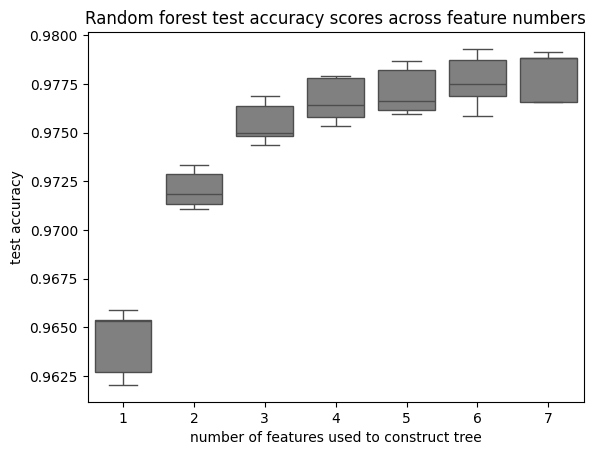

In [42]:
#plot the accuracy results
sns.boxplot(data = rf_results, x = 'max_features', y = 'test_scores', color = 'gray')
plt.xlabel('number of features used to construct tree')
plt.ylabel('test accuracy')
plt.title('Random forest test accuracy scores across feature numbers')
plt.show()

In [43]:
#print the optimized hyperparameter 'max_feature'
print(f"Optimal number of features to build tree classifiers: {grid_search.best_params_['max_features']}")

Optimal number of features to build tree classifiers: 7


### Linear Discriminant Analysis (LDA)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}


lda = LDA()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

X_lda = grid_search.transform(X_train)

#
print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)



#plot
plt.figure(figsize=(11,8))
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda[:, 0]), c=y_train, cmap = 'viridis', alpha=0.5)
plt.title('LDA Analysis of Spotify Data')
plt.xlabel('LD1')
plt.ylabel('Class')
plt.colorbar(label='Class')
plt.show()

In [ ]:
#Training ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_train_proba = grid_search.predict_proba(X_train)
y_test_proba = grid_search.predict_proba(X_test)


fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

#
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Final model

In [44]:
#define the best model
rf_model = grid_search.best_estimator_

#find the train accuracy
y_pred = rf_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy of random forest model on train set: {accuracy:.4f}")

#find the test accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of random forest model on test set: {accuracy:.4f}")

Accuracy of random forest model on train set: 1.0000
Accuracy of random forest model on test set: 0.9802


#### Confusion matrix

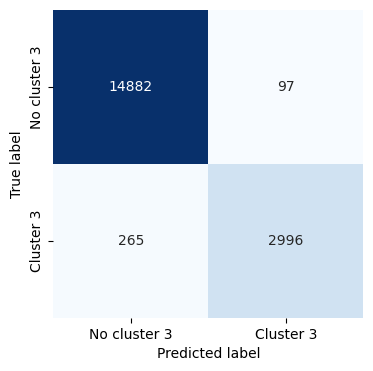

In [45]:
#create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize = (4,4))
sns.heatmap(cm, annot = True, cmap = 'Blues', cbar = False, fmt = 'd')
plt.xticks([0.5, 1.5], ['No cluster 3','Cluster 3'])
plt.yticks([0.5, 1.5], ['No cluster 3','Cluster 3'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### ROC and AUC

In [53]:
#calculate the predictive probabilities for the model
r_probs = [0 for _ in range(len(y_test))]
rf_probs_train = rf_model.predict_proba(X_train)[:, 1]
rf_probs_test = rf_model.predict_proba(X_test)[:, 1]

#calculate the ROC curves
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr_train, rf_tpr_train, _ = roc_curve(y_train, rf_probs_train)
rf_fpr_test, rf_tpr_test, _ = roc_curve(y_test, rf_probs_test)

#calculate AUC scores
r_auc = roc_auc_score(y_test, r_probs)
rf_auc_train = roc_auc_score(y_train, rf_probs_train)
rf_auc_test = roc_auc_score(y_test, rf_probs_test)

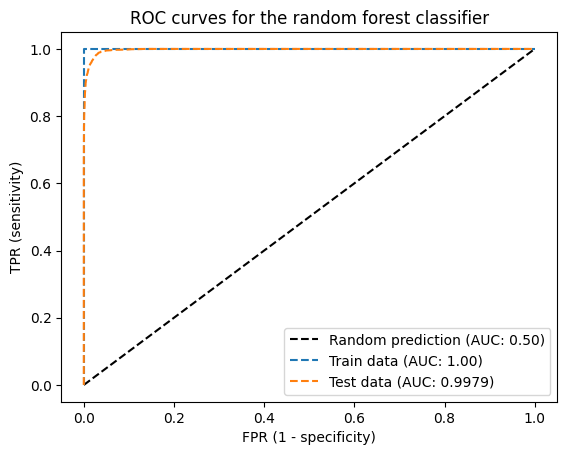

In [54]:
#plot the ROC curves
plt.plot(r_fpr, r_tpr, linestyle = '--', label = f"Random prediction (AUC: {r_auc:.2f})", c = 'black')
plt.plot(rf_fpr_train, rf_tpr_train, marker = '.', label = f"Train data (AUC: {rf_auc_train:.2f})")
plt.plot(rf_fpr_test, rf_tpr_test, marker = '.', label = f"Test data (AUC: {rf_auc_test:.4f})")
plt.xlabel('FPR (1 - specificity)')
plt.ylabel('TPR (sensitivity)')
plt.title('ROC curves for the random forest classifier')
plt.legend()
plt.show()

In [95]:
#Adaboost model
from sklearn.ensemble import AdaBoostClassifier

abc_clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)
abc_clf.fit(X_train, y_train)
yhat = abc_clf.predict(X_test)
(y_test == yhat).mean()

0.950109649122807

In [51]:
#SVC model
from sklearn import svm

svc_clf = svm.SVC()
svc_clf.fit(X_train, y_train)
yhat = svc_clf.predict(X_test)
(y_test == yhat).mean()